## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов.__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [181]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

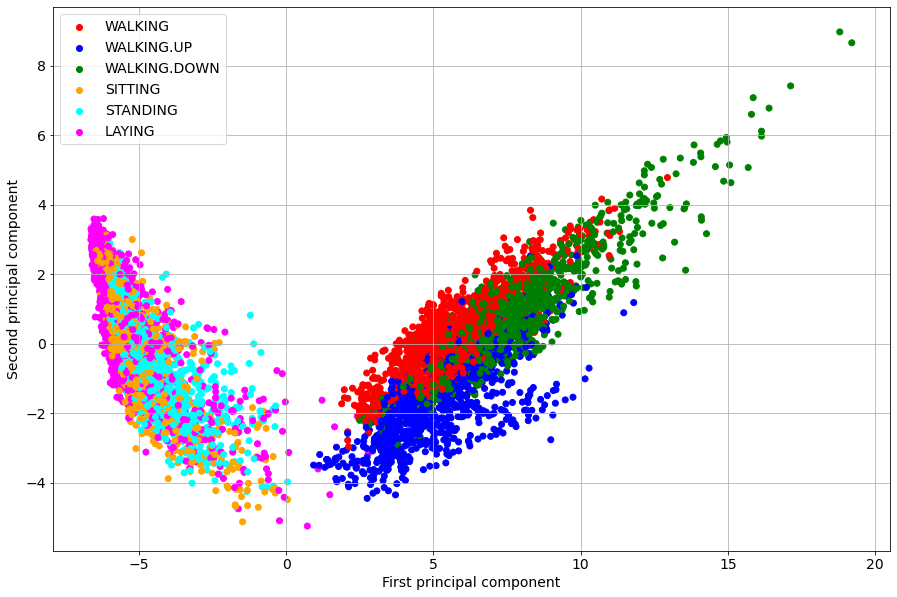

In [182]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [183]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [184]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [185]:
# Your experiments here

We could use LSTM, but the author of the post claims that it can give about 85-88% of accuracy, CNN works slightly better. So, let's try to use CNN. At first, we can look at the result of using our network from 'overfitting'.

In [186]:
type(X_train)

numpy.ndarray

In [187]:
#X_train, X_test = standardize(X_train, X_test)
import torch
import torch.nn as nn
import torchsummary
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [188]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

In [189]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [190]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 288),
            #nn.BatchNorm1d(288),
            nn.LeakyReLU(),
            #nn.Dropout(p = 0.6),
            nn.Linear(288, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        
    def __call__(self, inp):
        return self.forward(inp)

In [191]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [219]:
# def train_model(model, train_loader, val_loader, loss_fn, opt, n_epoches: int):
#     train_loss, val_loss = [], []
#     val_accuracy = []
#     loss_sum = batches = acc = 0
#     for epoch in range(n_epoches):
#         ep_train_loss = []
#         ep_val_loss = []
#         ep_val_accuracy = []
#         start_time = time.time()
        
#         model.train(True)
#         for X_batch, y_batch in train_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)
            
#             predictions = model(X_batch)
#             loss = loss_fn(predictions, y_batch)
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#             ep_train_loss.append(loss.item())
            
#         model.train(False)
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 batches += 1
#                 X_batch = X_batch.to(device)
#                 y_batch = y_batch.to(device)
                
#                 predictions = model(X_batch)
#                 loss = loss_fn(predictions, y_batch).item()
#                 loss_sum += loss
                
#                 ep_train_loss.append(loss)
#                 y_pred = predictions.max(dim=0)[1]
                
#                 #ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred().cpu()).numpy()))
#                 acc += (torch.argmax(predictions, dim=1) == y_batch).cpu().numpy().mean()
        
#         val_loss.append(loss_sum/batches)
#         val_accuracy.append(acc/batches)
#         train_loss.append(np.mean(ep_train_loss))
#         #val_loss.append(np.mean(ep_val_accuracy))
        
#     return train_loss, val_loss, val_accuracy

In [194]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch.squeeze(1))
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch.squeeze(1))

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.squeeze(1).cpu() == y_pred.cpu()).numpy()))

        
        print('Epoch number ', epoch + 1, ': took ', time.time() - start_time, 's')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, val_loss, val_accuracy

In [195]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, ax = plt.subplots(1, 2, figsize = (12,4))
    
    ax[0].set_title('Loss')
    ax[0].plot(train_loss, label = 'train')
    ax[0].plot(val_loss, label = 'test')
    ax[0].legend()
    
    ax[1].set_title('Test accuracy')
    ax[1].plot(val_accuracy)

In [196]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch number  1 : took  4.089653968811035 s
Epoch number  2 : took  3.9102978706359863 s
Epoch number  3 : took  4.1476171016693115 s
Epoch number  4 : took  3.795811891555786 s
Epoch number  5 : took  3.818026542663574 s
Epoch number  6 : took  3.7045979499816895 s
Epoch number  7 : took  4.274968147277832 s
Epoch number  8 : took  3.6383156776428223 s
Epoch number  9 : took  3.809114694595337 s
Epoch number  10 : took  3.864112615585327 s
Epoch number  11 : took  3.920114278793335 s
Epoch number  12 : took  3.8136041164398193 s
Epoch number  13 : took  3.8931972980499268 s
Epoch number  14 : took  3.776109218597412 s
Epoch number  15 : took  3.9663169384002686 s
Epoch number  16 : took  4.0228095054626465 s
Epoch number  17 : took  3.784538984298706 s
Epoch number  18 : took  3.624607563018799 s
Epoch number  19 : took  4.01165246963501 s
Epoch number  20 : took  4.317408800125122 s
Epoch number  21 : took  4.072162866592407 s
Epoch number  22 : took  4.170490741729736 s
Epoch number

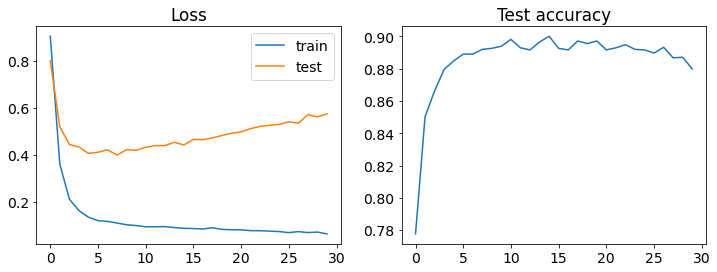

In [197]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [198]:
print('accuracy: ', val_accuracy[29])

accuracy:  0.8798828125


We see an overfitting, so let's use dropout

In [199]:
class TinyNeuralNetwork2(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 288),
            nn.Dropout(p = 0.6),
            #nn.BatchNorm1d(288),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(288, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        
    def __call__(self, inp):
        return self.forward(inp)

In [200]:
model1 = TinyNeuralNetwork2().to(device, torch.float32)
opt = torch.optim.Adam(model1.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()
train_loss1, val_loss1, val_accuracy1 = train_model(model1, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch number  1 : took  4.0425262451171875 s
Epoch number  2 : took  3.8703835010528564 s
Epoch number  3 : took  3.684044122695923 s
Epoch number  4 : took  4.22131609916687 s
Epoch number  5 : took  4.245378494262695 s
Epoch number  6 : took  4.132778882980347 s
Epoch number  7 : took  3.7449967861175537 s
Epoch number  8 : took  3.7200429439544678 s
Epoch number  9 : took  3.854989528656006 s
Epoch number  10 : took  3.6016671657562256 s
Epoch number  11 : took  3.7407290935516357 s
Epoch number  12 : took  4.0161285400390625 s
Epoch number  13 : took  3.903109312057495 s
Epoch number  14 : took  3.7282724380493164 s
Epoch number  15 : took  4.23383641242981 s
Epoch number  16 : took  3.8933489322662354 s
Epoch number  17 : took  4.158480405807495 s
Epoch number  18 : took  3.7626707553863525 s
Epoch number  19 : took  3.742891788482666 s
Epoch number  20 : took  3.808354616165161 s
Epoch number  21 : took  3.683777332305908 s
Epoch number  22 : took  4.016226053237915 s
Epoch numbe

In [201]:
print('accuracy: ', val_accuracy1[29])

accuracy:  0.8782552083333334


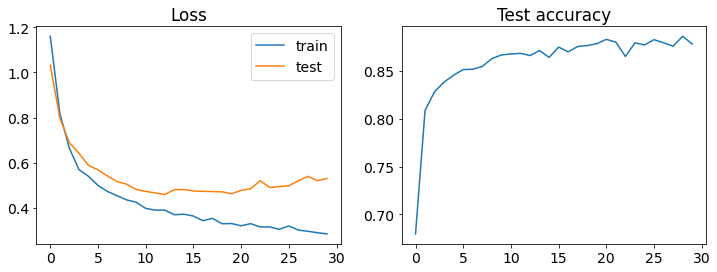

In [202]:
plot_train_process(train_loss1, val_loss1, val_accuracy1)

Dropout only in this case not very emproves results. Well, we still remember about batchnorm...

In [203]:
class TinyNeuralNetwork3(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 288),
            nn.BatchNorm1d(288),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(288, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        
    def __call__(self, inp):
        return self.forward(inp)

In [204]:
model1 = TinyNeuralNetwork3().to(device, torch.float32)
opt = torch.optim.Adam(model1.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()
train_loss1, val_loss1, val_accuracy1 = train_model(model1, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch number  1 : took  3.728499174118042 s
Epoch number  2 : took  4.11817193031311 s
Epoch number  3 : took  4.125013828277588 s
Epoch number  4 : took  3.92610502243042 s
Epoch number  5 : took  3.7544126510620117 s
Epoch number  6 : took  3.7328925132751465 s
Epoch number  7 : took  3.9803662300109863 s
Epoch number  8 : took  3.884399652481079 s
Epoch number  9 : took  3.7748563289642334 s
Epoch number  10 : took  3.768045663833618 s
Epoch number  11 : took  4.048618316650391 s
Epoch number  12 : took  3.835069179534912 s
Epoch number  13 : took  4.31000828742981 s
Epoch number  14 : took  3.999138355255127 s
Epoch number  15 : took  3.719064235687256 s
Epoch number  16 : took  3.727447032928467 s
Epoch number  17 : took  3.8767921924591064 s
Epoch number  18 : took  3.9364945888519287 s
Epoch number  19 : took  3.766172409057617 s
Epoch number  20 : took  3.831327199935913 s
Epoch number  21 : took  3.947664499282837 s
Epoch number  22 : took  3.8229992389678955 s
Epoch number  2

In [205]:
print('accuracy: ', val_accuracy1[29])

accuracy:  0.9069010416666666


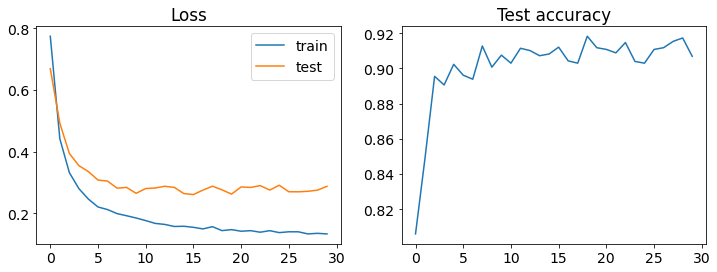

In [206]:
plot_train_process(train_loss1, val_loss1, val_accuracy1)

It looks more better, but let's try a network from 2nd part of our lab

In [207]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 576),
            nn.BatchNorm1d(576),
            nn.ReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(576, 288),
            nn.BatchNorm1d(288,),
            nn.ReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(288, 6)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
    def __call__(self, inp):
        return self.forward(inp)

In [208]:
model2 = FixedNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model2.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
train_loss2, val_loss2, val_accuracy2 = train_model(model2, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch number  1 : took  4.583462476730347 s
Epoch number  2 : took  4.292686939239502 s
Epoch number  3 : took  4.487234592437744 s
Epoch number  4 : took  4.417072296142578 s
Epoch number  5 : took  4.637120485305786 s
Epoch number  6 : took  4.082881450653076 s
Epoch number  7 : took  4.77835750579834 s
Epoch number  8 : took  4.831584692001343 s
Epoch number  9 : took  4.4182329177856445 s
Epoch number  10 : took  4.6656410694122314 s
Epoch number  11 : took  4.505330324172974 s
Epoch number  12 : took  4.220237970352173 s
Epoch number  13 : took  4.190641164779663 s
Epoch number  14 : took  4.589937925338745 s
Epoch number  15 : took  4.248501777648926 s
Epoch number  16 : took  4.631213426589966 s
Epoch number  17 : took  4.45508337020874 s
Epoch number  18 : took  4.571896076202393 s
Epoch number  19 : took  4.511301517486572 s
Epoch number  20 : took  5.029074668884277 s
Epoch number  21 : took  4.37866997718811 s
Epoch number  22 : took  4.260640621185303 s
Epoch number  23 : t

In [209]:
print('accuracy: ', val_accuracy2[29])

accuracy:  0.9215494791666666


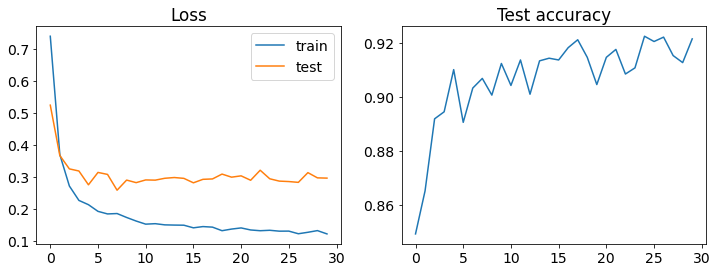

In [210]:
plot_train_process(train_loss2, val_loss2, val_accuracy2)

There are some doubts... Loss on the test jumps and seems big. Overfitting again? Maybe, there is not enough using only linear layers, so let's try to use convolutional layer

In [211]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self, input_shape=128*9, num_classes=6, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=9, stride=1, padding=0),
            nn.BatchNorm1d(1024),
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256,),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(128, 64),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
    
    def __call__(self, inp):
        return self.forward(inp)

In [212]:
model3 = ConvNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model3.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()
train_loss3, val_loss3, val_accuracy3 = train_model(model3, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch number  1 : took  7.097272157669067 s
Epoch number  2 : took  8.836015462875366 s
Epoch number  3 : took  8.591940641403198 s
Epoch number  4 : took  10.178545236587524 s
Epoch number  5 : took  9.245355606079102 s
Epoch number  6 : took  8.631109237670898 s
Epoch number  7 : took  7.79279899597168 s
Epoch number  8 : took  7.88335919380188 s
Epoch number  9 : took  7.908266544342041 s
Epoch number  10 : took  9.556680679321289 s
Epoch number  11 : took  7.8414342403411865 s
Epoch number  12 : took  6.878936052322388 s
Epoch number  13 : took  7.840856552124023 s
Epoch number  14 : took  7.683281898498535 s
Epoch number  15 : took  6.943885326385498 s
Epoch number  16 : took  7.765696048736572 s
Epoch number  17 : took  7.999468803405762 s
Epoch number  18 : took  8.297344207763672 s
Epoch number  19 : took  6.958240032196045 s
Epoch number  20 : took  7.31157374382019 s
Epoch number  21 : took  7.672854661941528 s
Epoch number  22 : took  7.97521710395813 s
Epoch number  23 : to

In [218]:
print('accuracy: ', val_accuracy3[29])

accuracy:  0.9069010416666666


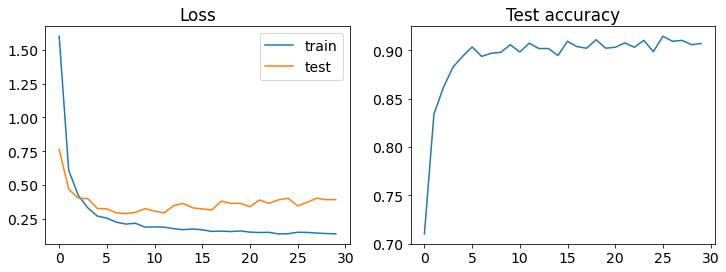

In [214]:
plot_train_process(train_loss3, val_loss3, val_accuracy3)

Graph looks better, but for some reasons accuracy didn't improve. Probably, there's a way to use a convolutional layer more progressively.

As a result, this task was resemble the 2nd part of lab, but with more difficult data. Also, we could solve it with LSTM, but the post gave a hint that it's a little worse in this task